<a href="https://colab.research.google.com/github/rethfor/Modified-Frozen-Lake-8x8/blob/main/Frozen_Lake_8x8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym[atari]
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (440 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 784 kB of 

In [2]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import time
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [3]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


********Average reward per thousand episodes********

5000 :  0.0059999999999999975
10000 :  0.032199999999999916
15000 :  0.051999999999999796
20000 :  0.0513999999999998
25000 :  0.061999999999999736
30000 :  0.06879999999999992
35000 :  0.06939999999999993
40000 :  0.0754000000000001
45000 :  0.08640000000000042
50000 :  0.09120000000000056
55000 :  0.15600000000000241
60000 :  0.2800000000000018
65000 :  0.368999999999992
70000 :  0.4459999999999835
75000 :  0.48039999999997973
80000 :  0.5197999999999754
85000 :  0.5543999999999716
90000 :  0.5525999999999718
95000 :  0.5803999999999687
100000 :  0.595999999999967
BEST: 0.595999999999967


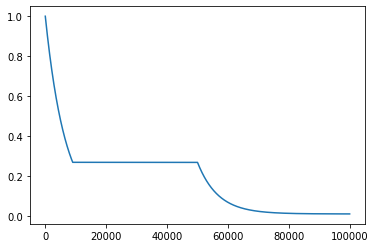

In [8]:
##########------------------- FROZEN LAKE WITH Q LEARNING ------------------###########
env = gym.make("FrozenLake-v0", map_name='8x8', is_slippery = True)

action_space_size = env.action_space.n
state_space_size = env.observation_space.n
q_table = np.zeros((state_space_size, action_space_size)) # Making the Q-table 
cnt = []
data_points = []
#print(q_table)
num_episodes = 100000
max_steps_per_episode = 100 #If by the one-hundredth step, the agent hasn’t reached the frisbee or fallen through a hole, then the episode will terminate with the agent receiving zero points.

lr = 0.75
discount_rate = 0.99
exploration_rate_inc = 0
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.0001492 #In time, agent will slowly exploit instead of explore

rewards_all_episodes = []
lr_array = np.linspace(lr, 1e-4, num=num_episodes)
#--->  Q-Learning algorithm  <---
for episode in range(num_episodes):
  state = env.reset()
  
  done = False
  rewards_current_episode = 0
  learning_rate = lr_array[episode]
  #for step in range(max_steps_per_episode):
  while True:
    # Exploration-Exploitation trade-off
    eps_greed_decider = random.uniform(0,1)
    if eps_greed_decider > exploration_rate:
      action = np.argmax(q_table[state,:]) # Returns indice of maximum number in Q-table's state row's columns.
    else:
      action = env.action_space.sample()
    
    new_state,reward,done,info = env.step(action)

    # Update Q-table for every new iteration of Q(s,a) using formula --> q_new(s,a) = (1-lr) * q(s,a) + lr*(new_Reward + discount * max(q(new_s, ))) 
    q_table[state,action] = q_table[state,action] * (1-learning_rate) + learning_rate * (reward + discount_rate * np.max(q_table[new_state,:]))

    state = new_state
    rewards_current_episode += reward

    if done:
      break
  if (episode < 9000):
    exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate * episode)  
  elif (episode > 50000):
    exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate * (episode-41000)) 
  rewards_all_episodes.append(rewards_current_episode)
  
  #if (episode % 50 == 0 and episode > 1000):
    #learning_rate -= 0.0003786

  if (episode % 10 == 0): 
    cnt.append(episode)
    data_points.append(exploration_rate)
    
plt.plot(cnt,data_points)   
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/5000)
count = 5000
cnt2 = 0
prev = 0
best = 0
print("********Average reward per thousand episodes********\n")
for r in rewards_per_thousand_episodes:
  print(count, ": ", str(sum(r/5000)))
  if (cnt2 >= 1):
    prev = sum(rewards_per_thousand_episodes[cnt2 - 1] / 5000)
    if (sum(r/5000) > prev):
      best = sum(r/5000)
  count += 5000
  cnt2 += 1
print("BEST: " + str(best))


In [ ]:
#print(sum(rewards_all_episodes[8000:8500]))
print(lr)
print(exploration_rate)
#print(exploration_rate_inc)
#print(q_table)
#env = gym.make("FrozenLake-v0", map_name='8x8', is_slippery = True)
#print(env.action_space.n)
#print(env.observation_space.n)
num_episodes = 100000
ar = np.linspace(0.75, 1e-7, num=num_episodes)
print(ar[3200])

1e-06
0.010085168395664226
0.7259997631976319


In [ ]:
#######----------------- BEST Q-TABLE I REACHED -------------- #########
import numpy as np
q_table = np.array([[0.26452294, 0.26613646, 0.26656467, 0.28013139],
 [0.26933106, 0.27439699, 0.29314411, 0.27652636],
 [0.28395002, 0.29384883, 0.31393364, 0.29720459],
 [0.30504765, 0.3109797,  0.3381818,  0.31892617],
 [0.33247853, 0.33796174, 0.36709438, 0.33847827],
 [0.36304827, 0.36481378, 0.39431049, 0.35597839],
 [0.38501954, 0.39110614, 0.4138721,  0.38250885],
 [0.39458281, 0.3941516,  0.4197703,  0.39215129],
 [0.24686283, 0.24691302, 0.25283133, 0.2761377 ],
 [0.26131141, 0.26114797, 0.26295562, 0.28624871],
 [0.2666005,  0.27981286, 0.27564178, 0.30442761],
 [0.1905619,  0.19437699, 0.21948393, 0.32683998],
 [0.3078826,  0.31883022, 0.3350329,  0.35631891],
 [0.35360923, 0.34844799, 0.39449457, 0.35708418],
 [0.39675084, 0.4018127,  0.42661244, 0.39160381],
 [0.40951143, 0.43859134, 0.41605558, 0.40743081],
 [0.20951888, 0.21586014, 0.20585094, 0.25240721],
 [0.20627524, 0.20016679, 0.21249881, 0.252533  ],
 [0.24436567, 0.12530887, 0.16440371, 0.15592645],
 [0.,         0.,         0.,         0.,       ],
 [0.19442185, 0.19875552, 0.30689173, 0.14842624],
 [0.23491081, 0.29782729, 0.2688668,  0.37703226],
 [0.40723423, 0.41911083, 0.44685703, 0.41255314],
 [0.44840992, 0.473201,   0.45780884, 0.44257491],
 [0.18284304, 0.17503981, 0.17931304, 0.22363936],
 [0.17124395, 0.15969083, 0.16909174, 0.21767849],
 [0.10124083, 0.09843858, 0.09918144, 0.18848509],
 [0.04155361, 0.04230855, 0.04306831, 0.12953594],
 [0.21411349, 0.08079812, 0.09363042, 0.09887189],
 [0.,         0.,         0.,         0.,       ],
 [0.28484071, 0.35291739, 0.46187516, 0.29039867],
 [0.48775843, 0.49979007, 0.52238125, 0.47038924],
 [0.14090196, 0.14232672, 0.14585391, 0.17235501],
 [0.04235531, 0.09386406, 0.09757136, 0.12196899],
 [0.03356048, 0.04022579, 0.02123837, 0.09891844],
 [0.,         0.,         0.,         0.,       ],
 [0.09946029, 0.15418122, 0.21318318, 0.13709581],
 [0.15160497, 0.28961907, 0.17208055, 0.18360036],
 [0.23452742, 0.24347314, 0.32989831, 0.44044039],
 [0.55854016, 0.53894874, 0.59780687, 0.50476727],
 [0.14486448, 0.07274504, 0.10101562, 0.07549308],
 [0.,         0.,         0.,         0.,       ],
 [0.,         0.,         0.,         0.,       ],
 [0.01265896, 0.0237676,  0.06585274, 0.00859239],
 [0.08231525, 0.05532724, 0.07780531, 0.16247446],
 [0.21883525, 0.09676195, 0.15259577, 0.1286103 ],
 [0.,         0.,         0.,         0.,       ],
 [0.49107643, 0.42842485, 0.7033427,  0.36068597],
 [0.12794584, 0.09655117, 0.11665131, 0.09145627],
 [0.,         0.,         0.,         0.,       ],
 [0.00270572, 0.00914939, 0.03102098, 0.00363344],
 [0.01240019, 0.00408433, 0.00679135, 0.02693024],
 [0.,         0.,         0.,         0.,       ],
 [0.21314803, 0.11248017, 0.10959323, 0.03352985],
 [0.,         0.,         0.,         0.,       ],
 [0.54919489, 0.66229448, 0.84634318, 0.38310199],
 [0.12103712, 0.11068552, 0.10772304, 0.11017812],
 [0.04396307, 0.07934198, 0.07102323, 0.07580173],
 [0.05638899, 0.0186164,  0.02164627, 0.01603856],
 [0.,         0.,         0.,         0.,       ],
 [0.05356393, 0.11674797, 0.18117365, 0.03736387],
 [0.19410815, 0.40036178, 0.24162139, 0.24419882],
 [0.44502559, 0.6887471,  0.42854506, 0.4378356 ],
 [0.,         0.,         0.,         0.,       ]])

In [ ]:
#------------ Watch Agent Through Learned Q-Table ------------------#
env = gym.make("FrozenLake-v0", map_name='8x8' , is_slippery = True)
from IPython.display import clear_output
counter = 0
for episode in range(5):
  state = env.reset()
  done = False
  print(" EPISODE: ", episode + 1, " \n\n\n\n")
  time.sleep(1)
  
  #for step in range(max_steps_per_episode):
  while True:
    clear_output(wait=True)
    env.render()
    time.sleep(0.1)

    action = np.argmax(q_table[state,:])
    new_state, reward, done, info = env.step(action)
  
    if done:
      clear_output(wait = True)
      env.render()
      if reward == 1:
        counter += 1
        print("******* Reached The Goal ********")
        time.sleep(3)
      else:
        print("******* Fell Through a Hole ********")
        time.sleep(3)
      clear_output(wait = True)
      break

    state = new_state

  print("Won: ",counter," out of 5" )

env.close()


Won:  2  out of 5


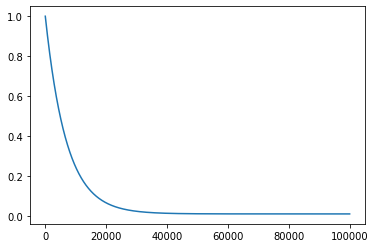

In [ ]:
#######------------------ TO TEST THE CURVE OF EXPLORATION RATE DECAY ------------------######
exploration_rate = 1
exploration_rate_inc = 0
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.0001442
cnt = []
data_points = []
for episode in range(100000):
  exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate * episode)

  if (episode % 5 == 0): 
    cnt.append(episode)
    data_points.append(exploration_rate)
plt.plot(cnt,data_points)    

In [ ]:
##########------------------- A BASIC INTRODUCTION TO PRIMITIVE REINFORCEMENT LEARNING ------------------###########
env = gym.make('CartPole-v0')
bestLength = 0
episode_lengths = []
best_weigths = np.zeros(4)
for i in range(100):
  new_weigths =  np.random.uniform(-1, 1, 4)
  length = []
#-- INITIALIZE WITH RANDOM WEIGTHS 100 TIMES --#
  for j in range(100):
    observation = env.reset()
    done = False
    cnt = 0
#-- PLAY THE GAME 10000 TIME --#   
    while True:
      cnt += 1
      action = 1 if np.dot(observation, new_weigths) > 0 else 0 
      observation, reward, done, info = env.step(action) 
      if done: 
        break
    length.append(cnt)  
#-----------------------------#  
  average_length = float(sum(length) / len(length))
  if average_length > bestLength:
    bestLength = average_length
    best_weigths = new_weigths   
  episode_lengths.append(average_length) 
  if i % 10 == 0:
    print('best length is ', bestLength)

done = False
cnt = 0
env = wrap_env(env)
observation = env.reset()
while True:
    env.render()
    cnt += 1
    action = 1 if np.dot(observation, best_weigths) > 0 else 0 
    observation, reward, done, info = env.step(action)
    if done: 
      break

env.close()
show_video()